# Parameters

In [1]:
#中文采用了清华NLP组提供的THUCNews新闻文本分类数据集的子集
source_folder = '../Data_En/pdata'
destination_folder = './model_xlnet_en'
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

# Libraries

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchtext
from torchtext.legacy import data
from torchtext.legacy import datasets
import torchtext
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torchtext.legacy.data import Field, TabularDataset, BucketIterator, Iterator
import torch.nn as nn
from transformers import XLNetModel, XLNetTokenizer, XLNetForSequenceClassification
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
from sklearn.model_selection import train_test_split
import spacy
from tqdm import tqdm, trange
import random
import math
import numpy as np
import matplotlib.pyplot as plt
from transformers import AdamW
use_cuda=torch.cuda.is_available()
device=torch.device("cuda" if use_cuda else "cpu")
from keras.preprocessing.sequence import pad_sequences
SEED=1234
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

torch.backends.cudnn.deterministic = True

In [3]:
import pandas as pd
df_train=pd.read_csv(source_folder+"/train.csv")
df_valid=pd.read_csv(source_folder+ '/valid.csv')
df_test=pd.read_csv(source_folder+ '/test.csv')



In [4]:
df_all = pd.concat([df_train,df_valid,df_test])
df_all = df_all.reset_index()
df_all = df_all.drop(['index'], axis=1)

In [5]:
df_all.head()

,label,title,text,titletext
0,0,Obamacare's unlikely No. 1 city,"Killing Obama administration rules, dismantlin...",Obamacare's unlikely No. 1 city. Killing Obama...
1,0,New York restores order for 2016 front-runners,Hillary Clinton and Donald Trump scored resoun...,New York restores order for 2016 front-runners...
2,0,These political scientists may have just disco...,There's a lot of disgust in America with polit...,These political scientists may have just disco...
3,0,"Hillary supporters: We're excited, too, but al...",Trump and Sanders get all the attention for th...,"Hillary supporters: We're excited, too, but al..."
4,0,Hung jury in Jodi Arias sentencing phase remov...,The jury in the Jodi Arias case tasked with de...,Hung jury in Jodi Arias sentencing phase remov...


In [7]:
df_all['titletext'][2000]

'The Murder Shaking San Francisco’s Liberal Soul. The man accused of shooting a young woman dead on a popular pier had served 181 months in federal prisons and been deported five times. But San Francisco’s sheriff saw fit to free him. Across the top of the letter, the man neatly lettered the words “Motion to Correct Sentence” and “United States V. Juan Francisco Lopez-Sanchez.” He is listed in this and most of his other court cases by that name and in others as Juan Jose Dominguez-De La Parra. His real name is said by federal authorities to most likely be Jose Inez Garcia Zarate. The authorities are not sure which of the various dates of birth he has provided is accurate. As Lopez-Sanchez, DOB 12/12/1980, he reminded the court in this letter from a federal correctional facility in Missouri that he was serving 51 months in federal prison for illegal reentry to the United States. He had also been sentenced to an added 21 months for violating the terms of his supervised release after a 19

In [9]:
sentences = df_all.titletext.values

In [11]:

labels = df_all.label.values

# 分词

In [12]:
from transformers import BertTokenizer
tokenizer = XLNetTokenizer.from_pretrained('../utils/chinese-xlnet-base', do_lower_case=False)

In [13]:
# xlnet的模型输入需要两个mask，不能依赖torchtext了
#格式：Sentence_A + [SEP] + Sentence_B + [SEP] + [CLS]
#本中文数据集有多句话组成，由于是新闻，由句号分割

In [14]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentences]
print ("Tokenize the first sentence:")
print (tokenized_texts[0])

Tokenize the first sentence:
['▁O', 'ba', 'ma', 'car', 'e', "'", 's', '▁', 'un', 'li', 'ke', 'ly', '▁No', '.', '▁', '1', '▁c', 'ity', '.', '▁K', 'ill', 'ing', '▁O', 'ba', 'ma', '▁', 'ad', 'min', 'ist', 'ration', '▁', 'ru', 'les', ',', '▁d', 'ism', 'ant', 'ling', '▁O', 'ba', 'ma', 'car', 'e', '▁', 'and', '▁p', 'ush', 'ing', '▁', 'th', 'rough', '▁', 'ta', 'x', '▁re', 'form', '▁', 'are', '▁', 'on', '▁', 'the', '▁', 'ear', 'ly', '▁', 'to', '-', 'do', '▁l', 'ist', '.']


In [19]:
#设备限制，虽然xlnet支持长段落，但这里还是128稳妥
MAX_LEN = 128

In [20]:
input_ids = [tokenizer.convert_tokens_to_ids(x) for x in tokenized_texts]

In [21]:
input_ids = pad_sequences(input_ids, maxlen=MAX_LEN, dtype="long", truncating="post", padding="post")

In [22]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [23]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, 
                                                            random_state=SEED, test_size=0.1)
train_masks, validation_masks, _, _ = train_test_split(attention_masks, input_ids,
                                             random_state=SEED, test_size=0.1)

In [24]:
train_inputs = torch.tensor(train_inputs)
validation_inputs = torch.tensor(validation_inputs)
train_labels = torch.tensor(train_labels)
validation_labels = torch.tensor(validation_labels)
train_masks = torch.tensor(train_masks)
validation_masks = torch.tensor(validation_masks)

In [25]:
batch_size = 16

# iterator of our data with torch DataLoader. 

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_masks, validation_labels)
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

# MODEL

In [26]:
model = XLNetForSequenceClassification.from_pretrained("../utils/chinese-xlnet-base", num_labels=2)
model.cuda()

Some weights of the model checkpoint at ../utils/chinese-xlnet-base were not used when initializing XLNetForSequenceClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at ../utils/chinese-xlnet-base and are newly initialized: ['sequence_summary.summary.weight', 'sequence_summary.summary.bias', 'logits_proj.weight', 'logits_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to us

XLNetForSequenceClassification(
  (transformer): XLNetModel(
    (word_embedding): Embedding(32000, 768)
    (layer): ModuleList(
      (0): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (layer_1): Linear(in_features=768, out_features=3072, bias=True)
          (layer_2): Linear(in_features=3072, out_features=768, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (1): XLNetLayer(
        (rel_attn): XLNetRelativeAttention(
          (layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (ff): XLNetFeedForward(
          (layer_norm): LayerNorm((768,), eps=1e

In [27]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]



In [28]:
optimizer = AdamW(optimizer_grouped_parameters,
                     lr=2e-5)

In [29]:
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [30]:
# Store our loss and accuracy for plotting
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 4

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
    model.train()
  
  # Tracking variables
    tr_loss = 0
    nb_tr_examples, nb_tr_steps = 0, 0

    # Train the data for one epoch
    for step, batch in enumerate(train_dataloader):
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Clear out the gradients (by default they accumulate)
        optimizer.zero_grad()
        # Forward pass
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels=b_labels)
        loss = outputs[0]
        logits = outputs[1]
        train_loss_set.append(loss.item())    
        # Backward pass
        loss.backward()
        # Update parameters and take a step using the computed gradient
        optimizer.step()


        # Update tracking variables
        tr_loss += loss.item()
        nb_tr_examples += b_input_ids.size(0)
        nb_tr_steps += 1

    print("Train loss: {}".format(tr_loss/nb_tr_steps))


    # Validation

    # Put model in evaluation mode to evaluate loss on the validation set
    model.eval()

    # Tracking variables 
    eval_loss, eval_accuracy = 0, 0
    nb_eval_steps, nb_eval_examples = 0, 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        # Add batch to GPU
        batch = tuple(t.to(device) for t in batch)
        # Unpack the inputs from our dataloader
        b_input_ids, b_input_mask, b_labels = batch
        # Telling the model not to compute or store gradients, saving memory and speeding up validation
        with torch.no_grad():
            # Forward pass, calculate logit predictions
            output = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = output[0]

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        tmp_eval_accuracy = flat_accuracy(logits, label_ids)

        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1

    print("Validation Accuracy: {}".format(eval_accuracy/nb_eval_steps))

Epoch:   0%|          | 0/4 [00:00<?, ?it/s]

Train loss: 0.3390589170262847


Epoch:  25%|██▌       | 1/4 [01:27<04:22, 87.54s/it]

Validation Accuracy: 0.9328125
Train loss: 0.13284426200019955


Epoch:  50%|█████     | 2/4 [02:55<02:55, 87.78s/it]

Validation Accuracy: 0.9375
Train loss: 0.0796769509229704


Epoch:  75%|███████▌  | 3/4 [04:23<01:27, 87.88s/it]

Validation Accuracy: 0.95
Train loss: 0.05601645338736002


Epoch: 100%|██████████| 4/4 [05:51<00:00, 87.90s/it]

Validation Accuracy: 0.953125


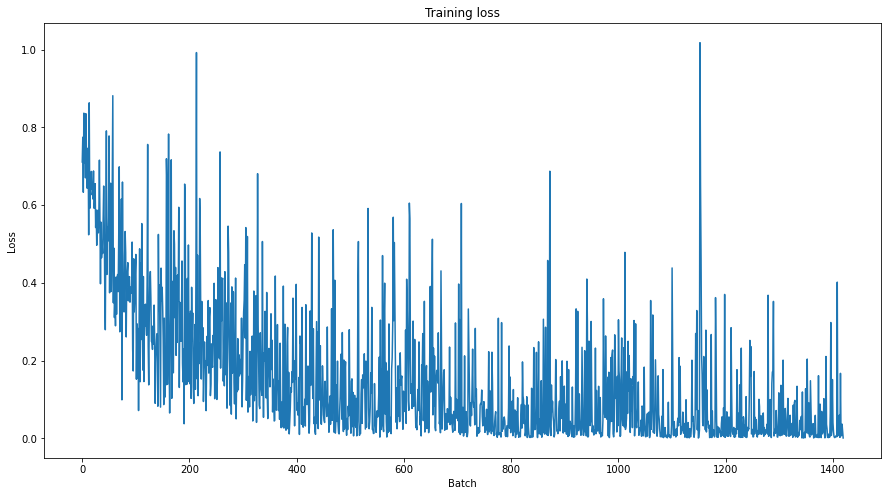

In [31]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()